In [1]:
import vitaldb
import pandas as pd
import requests
import json
import io
import time  # Importer time-modulet
import numpy as np

# Show all rows
pd.set_option('display.max_rows', None)  

# Show all columns
pd.set_option('display.max_columns', None)  

# Prevent truncation of column width
pd.set_option('display.max_colwidth', None)

# Prevent scientific notation (optional)
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
#Tracklist inneholder informationene: case identifier, track name(navnet på målingen og apparat), 

# track identifier (den konkrete patients konktere måling)
track_list_url = "https://api.vitaldb.net/trks"
df_tracklist = pd.read_csv(track_list_url) #Skriv tracklist_url inne i parantesen
df_tracklist.to_csv("trks.csv", index=False)

# Hent laboratoriedata fra API
laboratory_list_url = "https://api.vitaldb.net/labs"
df_laboratory = pd.read_csv(laboratory_list_url)

#Download clinical information
clinical_information_url = "https://api.vitaldb.net/cases"
df_clinical= pd.read_csv(clinical_information_url)

days_in_icu = pd.read_csv('C:/Users/johns/Documents/10semester/P10/For_machinelearning/number_of_days_in_ICU.csv')

days_in_icu = days_in_icu.drop('icu_days', axis='columns')
print(days_in_icu.head())


   caseid  icu_days_binary
0       1                0
1       2                0
2       3                0
3       4                1
4       5                1


In [7]:
clincial=df_clinical[['caseid','age','weight', 'height', 'bmi']]
sex=df_clinical[['caseid', 'sex']]
aline=df_clinical['aline1']
admission=df_clinical['opname']

print(admission)
#sex = pd.DataFrame(sex)

df_sex_icu = days_in_icu.merge(sex, on='caseid')
df_clinical_icu = days_in_icu.merge(clincial, on='caseid')

#print(df_sex_icu.head())

#sex_icu = df_sex_icu[df_sex_icu['icu_days_binary'] == 1]
#sex_noicu = df_sex_icu[df_sex_icu['icu_days_binary'] == 0]

#clinical_icu =df_clinical_icu[df_clinical_icu['icu_days_binary'] == 1]
#clinical_noicu = df_clinical_icu[df_clinical_icu['icu_days_binary'] == 0]

#print(sex_icu.head())

#print('males in ICU', (sex_icu['sex'] == 'M').sum())
#print('females in ICU', (sex_icu['sex'] == 'F').sum())

#print('males in no ICU', (sex_noicu['sex'] == 'M').sum())
#print('females in no ICU', (sex_noicu['sex'] == 'F').sum())

#print('mean clinical icu', clinical_icu.mean())
#print('mean clinical no icu', clinical_noicu.mean())

#print('std clinical icu', clinical_icu.std())
#print('std clinical no icu', clinical_noicu.std())



#print('mean:',clincial.mean())


#print('std', clincial.std())


count_male = (df_clinical['sex'] == 'M').sum()
print("Occurrences of 'M':", count_male)

count_female = (df_clinical['sex'] == 'F').sum()
print("Occurrences of 'F':", count_female)






0                                                 Low anterior resection
1                                                   Subtotal gastrectomy
2                                                        Cholecystectomy
3                                                     Distal gastrectomy
4                                                      Aneurysmal repair
5                                                        Cholecystectomy
6                                                         Lung lobectomy
7                                              Breast-conserving surgery
8                                                        Cholecystectomy
9                                                     Distal gastrectomy
10                              Transurethral resection of bladder tumor
11                                                 Liver transplantation
12                                                        Metastasectomy
13                                                 

In [ ]:

pat_in_ICU = pd.read_csv("C:/Users/johns/Documents/10semester/P10/For_machinelearning/number_of_days_in_ICU.csv")

pat_in_ICU = pat_in_ICU[['caseid', 'icu_days_binary']]

ICU_patients = []
non_ICU_patients = []

#print(pat_in_ICU['caseid'].head())

#df_laboratory[df_laboratory['caseid'] == value]

def divide_into_ICU_and_non_ICU_patients():
    for index, row in pat_in_ICU.iterrows():
        if pat_in_ICU[pat_in_ICU['icu_days_binary'] == 1]:
            ICU_patients = pat_in_ICU['caseid']
        else: 
            non_ICU_patients = pat_in_ICU['caseid']

divide_into_ICU_and_non_ICU_patients()



In [ ]:
# DENNE FUNGERER NÅ!!!!!!!!!!!!!!!!  Til maria

#Denne koden henter EEG- og fysiologiske signaler fra en API, analyserer dem for datakvalitet, 
#og lagrer relevant informasjon i en CSV-fil hvis signalene oppfyller gitte kriterier.



# Liste for spesielle variabler
special_variables = {
    "SNUADC/ART", "SNUADC/CVP", "SNUADC/ECG_II", "SNUADC/ECG_V5",
    "SNUADC/FEM", "SNUADC/PLETH", "Primus/AWP", "Primus/CO2",
    "BIS/EEG1_WAV", "BIS/EEG2_WAV", "CardioQ/ABP", "CardioQ/FLOW"
}

# Liste for å lagre data som skal skrives til CSV
saved_tracks = []


# trackdata_url = f"https://api.vitaldb.net/0aa685df768489a18a5e9f53af0d83bf60890c73"
# response = requests.get(trackdata_url, timeout = 10)
# trackdata = pd.read_csv(io.StringIO(response.text)) 
# trackdata.to_csv("data/test.csv", index=False)


def collect_track_null_checker():
    # Hent hver trackidentifierverdi
    for index, row in df_tracklist.iterrows():
        if row['tname'] in special_variables:
            trackidentifier = row["tid"]
            trackdata_url = f"https://api.vitaldb.net/{trackidentifier}"
            
            # Handles API error

            try:
                response = requests.get(trackdata_url, timeout = 10)
                response.raise_for_status()
            except requests.exceptions.Timeout:
                print(f"Timeout-error: Can not get {row['tname']} ({trackdata_url})")
                continue # Go to next signal

            try:
                # Konverter API-respons til en pandas DataFrame
                trackdata = pd.read_csv(io.StringIO(response.text)) 
                if trackdata.empty:
                    continue
            except:
                continue


            data_column = trackdata.columns[1]  # Velger den andre kolonnen (indeks 1)

            # Tell antall nullverdier, nanveridr, totalt antall missing verdier, og find samplingsperiode
            zero_count = (trackdata[data_column] == 0).sum().sum()
            nan_count_per_column = trackdata[data_column].isna().sum().sum()
            total_non_value = zero_count+nan_count_per_column
            size = trackdata[data_column].size
            samplingperiode = trackdata.iloc[0,1]

            # Sjekk om mer enn 20% av verdiene er null
            
            if total_non_value >= 0.2 * size:
                print(f"index: {index} ,NO.This track, {trackdata.columns[1]}, has {zero_count} 0s, {nan_count_per_column} NAN, combined {total_non_value} non informatory values out of {size} samples")
            else:
                print(f"index: {index} ,Saved.This track, {trackdata.columns[1]}, has {zero_count} 0s, {nan_count_per_column} NAN, combined {total_non_value} non informatory values out of {size} samples")
                # Lagre caseid, tname og tid
                saved_tracks.append([row["caseid"], row["tname"], row["tid"], nan_count_per_column, zero_count, size, samplingperiode])
                trackdata.to_csv(f"data/{trackidentifier}.csv",index=False)
            # Vent 2 sekunder før neste forespørsel
            # time.sleep(2)
        else:
            print(f"index: {index} ,Did not have special_variables")

    # Konverter listen til en DataFrame og lagre som CSV
    if saved_tracks:
        df_saved_tracks = pd.DataFrame(saved_tracks, columns=["caseid", "tname", "tid", "nan_count_per_column","zero_count", "size", "samplingperiode"])
        df_saved_tracks.to_csv("saved_tracks.csv", index=False)
        print("CSV file 'saved_tracks.csv' has been saved.")
    else:
        print("No tracks met the criteria for saving.")

# Kjør funksjonen
collect_track_null_checker()



KeyboardInterrupt: 

In [ ]:
special_variables = {'Solar8000/PLETH_HR'}

save_numerical_tracks = []

def count_missing_vaules_in_numeric_tracks():
    for index, row in df_tracklist.iterrows():
        if row['tname'] in special_variables:
            trackid= row['tid']
            caseid = row['caseid']
            print('Caseid', caseid, 'TrackName:', row['tname'])
            trackdata_url = f"https://api.vitaldb.net/{trackid}"

            response = requests.get(trackdata_url)
            trackdata = pd.read_csv(io.StringIO(response.text))
        
            time_before_start = trackdata.iloc[0,0]

            min_gap = trackdata.iloc[:20]['Time'].diff().min()
            min_gap = round(min_gap, 0)
            print('Min Gap:', min_gap)

            sampled_times = trackdata['Time'].diff()

            total_length_of_singal = len(trackdata['Time'])

            res = sum(x > min_gap for x in sampled_times[1:])
            print(res)

            if res > 0.2*total_length_of_singal:
                print('No, this signal has length', total_length_of_singal, 'and there are missing', res, 'values')
            
            else:
                print('Yes, this signal has length', total_length_of_singal, 'and are missing', res, 'values')
                save_numerical_tracks.append([row['caseid'], row['tname'], row['tid'], res, total_length_of_singal, min_gap])

    # Konverter listen til en DataFrame og lagre som CSV
    if save_numerical_tracks:
        df_saved_tracks = pd.DataFrame(save_numerical_tracks, columns=["caseid", "tname", "tid", "res","total_length_of_singal", "min_gap"])
        df_saved_tracks.to_csv("saved_tracks_numerical.csv", index=False)
        print("CSV file 'saved_tracks.csv' has been saved.")
    else:
        print("No tracks met the criteria for saving.")

    
count_missing_vaules_in_numeric_tracks()


KeyboardInterrupt: 

In [23]:
pd.set_option('display.max_rows', None)
def count_tracks ():
    counts = df_tracklist['tname'].value_counts()
    display(counts)
        
count_tracks()

tname
Solar8000/HR                6387
Solar8000/PLETH_HR          6386
Solar8000/PLETH_SPO2        6386
Primus/CO2                  6362
Primus/PAMB_MBAR            6361
Primus/SET_AGE              6361
Primus/AWP                  6360
SNUADC/ECG_II               6355
Primus/VENT_LEAK            6344
Primus/ETCO2                6339
Primus/FEN2O                6339
Primus/FIN2O                6339
Primus/INCO2                6339
Primus/MAC                  6338
Primus/MAWP_MBAR            6338
Primus/FEO2                 6335
Primus/FIO2                 6335
Primus/RR_CO2               6328
Solar8000/VENT_MAWP         6299
Solar8000/ETCO2             6242
Solar8000/INCO2             6242
Solar8000/FEO2              6239
Solar8000/FIO2              6239
Solar8000/RR_CO2            6177
SNUADC/PLETH                6157
Primus/SET_FIO2             6047
Primus/SET_FRESH_FLOW       6042
Primus/MV                   6022
Primus/TV                   6018
Primus/COMPLIANCE           6017
Prim

In [ ]:

def count_lab_results ():
    counts=df_laboratory.groupby('name')['caseid'].nunique()
    display(counts)
        
#count_lab_results()


def collect_laboratory_values_two_inputs(caseid, var_name):
    """
    Henter laboratorieværdier for en given patient (caseid) og en specifik laboratorievariabel (var_name).
    """
    if not isinstance(caseid, int) or not isinstance(var_name, str):
        return "Ugyldig input, vennligst bruk en integer for caseid og en string for variabelnavn"
    
    # Filtrer på både caseid og variabelnavn
    filtered_df = df_laboratory[(df_laboratory['caseid'] == caseid) & (df_laboratory['name'] == var_name)]
    
    # Hvis ingen resultater findes
    if filtered_df.empty:
        return f"Ingen data fundet for caseid {caseid} og variabel '{var_name}'"
    
    return filtered_df[['caseid', 'dt', 'result']]  # Returns caseid, time and results

# Eksempel på kald
caseid_test = 4  # Erstat med en reel caseid
variable_test = "cr"  # Erstat med en reel laboratorievariabel

print(collect_laboratory_values_two_inputs(caseid_test, variable_test))

#Denne funksjonen krevet et input, enten caseid eller variabelnavn. 
# Henter enten all information ift caseif eller all information ift variabelnavn

def collect_laboratory_values(value):
    if isinstance(value, int):  # Hvis input er patient caseid
        filtered_df = df_laboratory[df_laboratory['caseid'] == value]
        data_array = filtered_df[['dt', 'name', 'result']].values
        return [['dt', 'name', 'result']] + data_array.tolist()  # Include column names

    elif isinstance(value, str):  # Hvis input er en variabelnavn
        filtered_df = df_laboratory[df_laboratory['name'] == value]
        data_array = filtered_df[['dt', 'caseid', 'result']].values
        return [['dt', 'caseid', 'result']] + data_array.tolist()  # Include column names

    else:
        return "Ugyldig input, vennligst bruk enten en integer eller en string"

# Test function
#collect_laboratory_values(1)  # Example caseid
collect_laboratory_values("sao2")  #Example variable name




     caseid      dt  result
289       4  434356    0.66
290       4   84859    0.68
291       4  606476    0.76
292       4   21562    0.83
293       4  173382    0.87


[['dt', 'caseid', 'result'],
 [4628.0, 1.0, 96.0],
 [3060.0, 1.0, 100.0],
 [8921.0, 1.0, 100.0],
 [3078.0, 4.0, 97.0],
 [7460.0, 4.0, 98.0],
 [13624.0, 4.0, 99.0],
 [24374.0, 4.0, 99.0],
 [19934.0, 4.0, 100.0],
 [28903.0, 4.0, 100.0],
 [444425.0, 5.0, 97.0],
 [51065.0, 5.0, 99.0],
 [162205.0, 5.0, 99.0],
 [167131.0, 5.0, 99.0],
 [177839.0, 5.0, 99.0],
 [7172.0, 5.0, 100.0],
 [9947.0, 5.0, 100.0],
 [12310.0, 5.0, 100.0],
 [15000.0, 5.0, 100.0],
 [17498.0, 5.0, 100.0],
 [4092.0, 7.0, 99.0],
 [16294.0, 7.0, 99.0],
 [10855.0, 7.0, 100.0],
 [2827.0, 10.0, 97.0],
 [8502.0, 10.0, 99.0],
 [13597.0, 10.0, 100.0],
 [5412.0, 12.0, 83.0],
 [8555.0, 12.0, 94.0],
 [24395.0, 12.0, 98.0],
 [28212.0, 12.0, 98.0],
 [26697.0, 12.0, 98.0],
 [5099.0, 12.0, 98.0],
 [22845.0, 12.0, 99.0],
 [22413.0, 12.0, 99.0],
 [14879.0, 12.0, 99.0],
 [3413.0, 13.0, 99.0],
 [9230.0, 16.0, 95.0],
 [8276.0, 16.0, 96.0],
 [10447.0, 16.0, 99.0],
 [908.0, 16.0, 100.0],
 [1791.0, 17.0, 95.0],
 [12674.0, 17.0, 96.0],
 [8772.0, 17

     Time  SNUADC/ECG_II
0   0.000            NaN
1   0.002            NaN
2     NaN            NaN
3     NaN            NaN
4     NaN            NaN
5     NaN            NaN
6     NaN            NaN
7     NaN            NaN
8     NaN            NaN
9     NaN            NaN
10    NaN            NaN
11    NaN            NaN
12    NaN            NaN
13    NaN            NaN
14    NaN            NaN
15    NaN            NaN
16    NaN            NaN
17    NaN            NaN
18    NaN            NaN
19    NaN            NaN
20    NaN            NaN
21    NaN            NaN
22    NaN            NaN
23    NaN            NaN
24    NaN            NaN
25    NaN            NaN
26    NaN            NaN
27    NaN            NaN
28    NaN            NaN
29    NaN            NaN
30    NaN            NaN
31    NaN            NaN
32    NaN            NaN
33    NaN            NaN
34    NaN            NaN
35    NaN            NaN
36    NaN            NaN
37    NaN            NaN
38    NaN            NaN


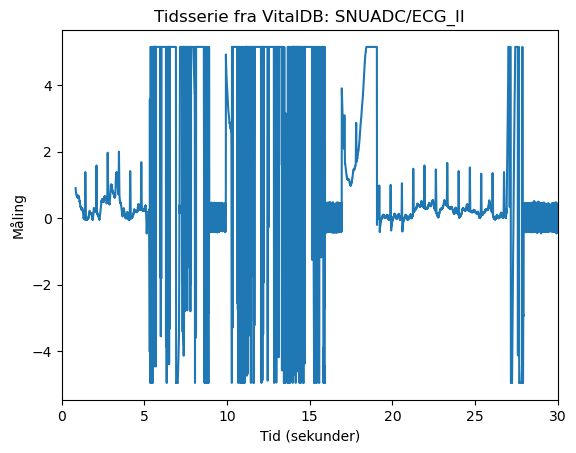

In [18]:
#HVIS MAN VIL PLOTTE ET Waveform data track. 
pd.set_option("display.max_rows", None)  # Vis alle rader
import numpy as np
import matplotlib.pyplot as plt

#LOADER SIGNALET  
trackdata_url = "http://api.vitaldb.net/8c9161aaae8cb578e2aa7b60f44234d98d2b3344"
response = requests.get(trackdata_url)
trackdata = pd.read_csv(io.StringIO(response.text))
print(trackdata.iloc[:1000]) 


#Henter ut signalfrekvensen, men bruker den ikke til noe her
signal_frequency = trackdata.iloc[1, 0]

#Starttid og endetidspunkt af signalet
start_time = trackdata.iloc[0,0]
end_time = trackdata.iloc[-1,0]
num_samples = len(trackdata)


# Generér tidsakse fra start til slut med korrekt sampling-rate
#time_axis = np.arange(start_time, end_time, signal_frequency)
time_axis = np.linspace(start_time, end_time, num_samples)

# Sikrer at tidsaksen har samme længde som trackdata
time_axis = time_axis[:len(trackdata)]

plt.plot(time_axis, trackdata.iloc[:, 1]) # Plotte Time vs. måling
plt.xlabel("Tid (sekunder)")
plt.xlim(0, 30)
plt.ylabel("Måling")
plt.title(f"Tidsserie fra VitalDB: {trackdata.columns[1]}")
plt.show()

Samplenumbers: 5348
Total mean 119.21765145848916
Outsnip mean 122.77146171693735


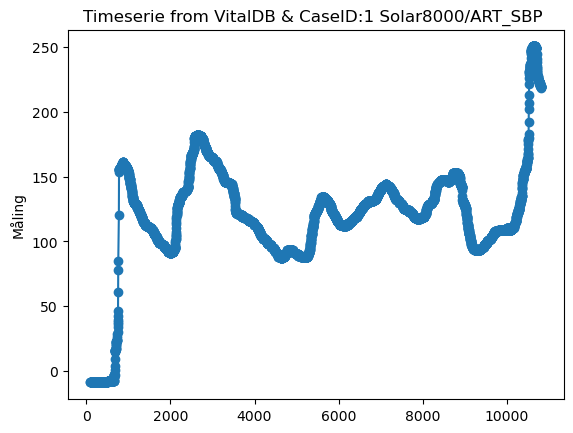

In [30]:
import numpy as np
import matplotlib.pyplot as plt

#If you want to plot a data track

             #Example: (1, 'Solar8000/ART_SBP')
def caseid_and_variable(caseid, var_name):
    if not isinstance(caseid, int) or not isinstance(var_name, str):
        return "Unvalid input"
    
    trackid_df = df_tracklist[(df_tracklist['caseid'] == caseid) & (df_tracklist['tname'] == var_name)]

    row = trackid_df.iloc[0]  # Get the first row (if multiple exist)
    if trackid_df.empty: 
        return f" No aviable data found for caseid {caseid} and variable '{var_name}'"
    
    return row['caseid'], row['tname'], row['tid']


inputname = 'Solar8000/ART_SBP'
caseid, tname, trackid = caseid_and_variable(1, inputname)


#LOADER SIGNALET  
trackdata_url = f"http://api.vitaldb.net/{trackid}"
response = requests.get(trackdata_url)
trackdata = pd.read_csv(io.StringIO(response.text))
#print(trackdata)

median_filtered = trackdata.iloc[:,1].rolling(window=100, center=True).median()

#print(median_filtered)
#print(trackdata)

print('Samplenumbers:', len(trackdata['Time']))

a = trackdata[inputname].mean()
print('Total mean', a)
b = trackdata[inputname].iloc[764:5074].mean()
print('Outsnip mean', b)

plt.plot(trackdata["Time"], median_filtered, marker='o', linestyle='-') # Plotte Time vs. måling
#plt.xlabel("Tid (sekunder)")
plt.ylabel("Måling")
#plt.xlim(100,150)
plt.title(f"Timeserie from VitalDB & CaseID:{caseid} {tname} ")
plt.show()